In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.metrics import accuracy_score

In [2]:
class IndicSentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [3]:
import pandas as pd

# Load the dataset from a CSV file
df = pd.read_csv('dataset_test.csv')

# Print the column names of the DataFrame
print(df.columns)

Index(['GENERIC CATEGORIES', 'CATEGORY', 'SUB-CATEGORY', 'PRODUCT', 'BRAND',
       'ASPECTS', 'ASPECT COMBO', 'ENGLISH REVIEW', 'LABEL', 'INDIC REVIEW'],
      dtype='object')


In [4]:
# Extract the reviews and labels
reviews = df['INDIC REVIEW'].tolist()  
labels = df['LABEL'].tolist()

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [5]:
# Split the dataset into train and test sets
reviews_train, reviews_test, labels_train, labels_test = train_test_split(reviews, labels_encoded, test_size=0.2, random_state=42)

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

encodings_train = tokenizer(reviews_train, truncation=True, padding=True)
encodings_test = tokenizer(reviews_test, truncation=True, padding=True)

dataset_train = IndicSentimentDataset(encodings_train, labels_train)
dataset_test = IndicSentimentDataset(encodings_test, labels_test)

In [6]:
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=len(label_encoder.classes_))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
def train(model, dataloader, optimizer, device, scheduler):
    model.train()
    total_loss = 0
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
    avg_loss = total_loss / len(dataloader)
    return avg_loss

def evaluate(model, dataloader, device):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits
            predicted_labels = torch.argmax(logits, dim=1)
            predictions.extend(predicted_labels.cpu().numpy().tolist())
            true_labels.extend(labels.cpu().numpy().tolist())
    accuracy = accuracy_score(true_labels, predictions)
    return accuracy

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 8
epochs = 3
learning_rate = 2e-5
warmup_steps = 100

train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

optimizer = AdamW(model.parameters(), lr=learning_rate)
num_training_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=num_training_steps)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    avg_train_loss = train(model, train_dataloader, optimizer, device, scheduler)
    accuracy = evaluate(model, test_dataloader, device)
    print(f"Train Loss: {avg_train_loss:.2f}")
    print(f"Test Accuracy: {accuracy:.2f}")


c:\Users\ASUS\anaconda3\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3


In [ ]:
print(f"Test Accuracy: {accuracy * 100:.2f}")

Test Accuracy: 85.50


In [ ]:
def predict_with_label(model, tokenizer, text, label_encoder, device):
    encoded_text = tokenizer(text, truncation=True, padding=True, return_tensors='pt').to(device)
    with torch.no_grad():
        output = model(**encoded_text)
        logits = output.logits
        predicted_label_id = torch.argmax(logits, dim=1).item()
        predicted_label = label_encoder.inverse_transform([predicted_label_id])[0]
        return predicted_label

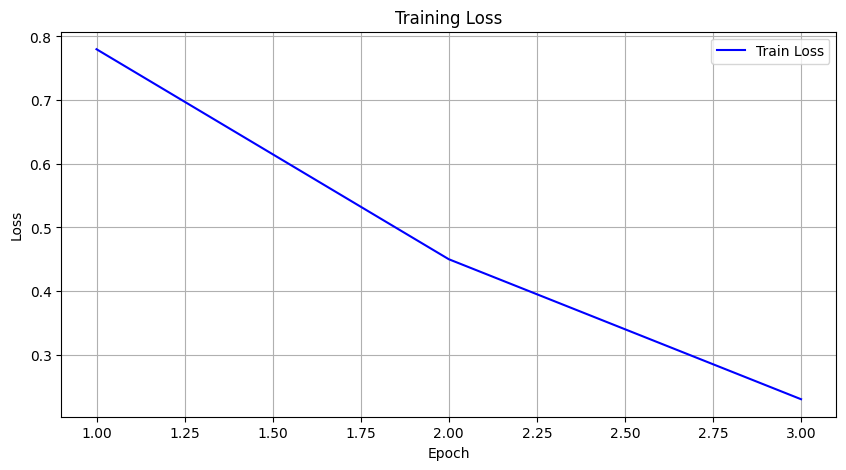

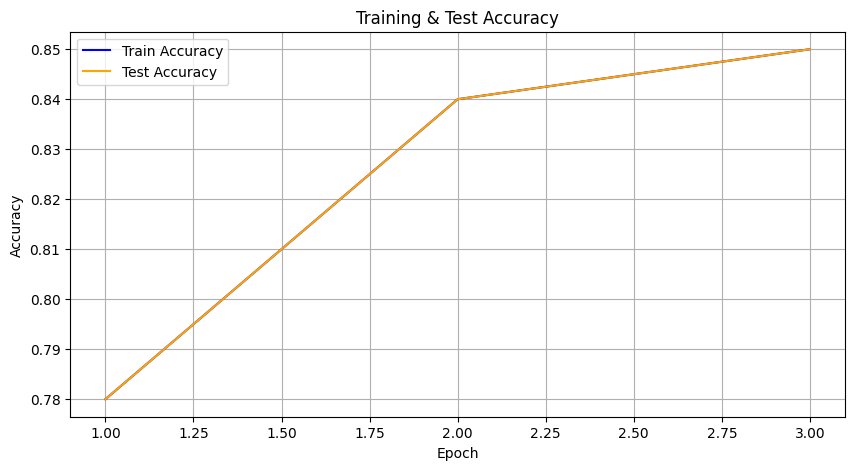

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(history['loss']) + 1), history['loss'], label='Train Loss', color='blue')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot test accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(history['accuracy']) + 1), history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(range(1, len(history['val_accuracy']) + 1), history['val_accuracy'], label='Test Accuracy', color='orange')
    plt.title('Training & Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example history dictionary format:
history = {
    'loss': [0.78, 0.45, 0.23],
    'accuracy': [0.78, 0.84, 0.85],
    'val_accuracy': [0.78, 0.84, 0.85]
}

# Plot the training history
plot_training_history(history)


In [ ]:
# Test predictions on new data
new_text = "ನೀವು ಅಪ್ಲಿಕೇಶನ್‌ನೊಂದಿಗೆ ಏನನ್ನು ಹಂಚಿಕೊಳ್ಳಲು ಬಯಸುತ್ತೀರಿ ಎಂಬುದನ್ನು ನಿಯಂತ್ರಿಸಲು ಇದು ನಿಮಗೆ ಅನುಮತಿಸುತ್ತದೆ. ಮತ್ತು ಅವರು ನಿಜವಾಗಿಯೂ ನಿಮ್ಮ ಖಾಸಗಿ ಜಾಗದಲ್ಲಿ ನಿಕ್ಕ್ ಮಾಡುವುದಿಲ್ಲ."
predicted_label = predict_with_label(model, tokenizer, new_text, label_encoder, device)
print("Predicted Label:", predicted_label)

Predicted Label: Negative


In [ ]:
# After training

# Define the directory path where you want to save the model
model_directory = "bert_model/"

# Save the model and tokenizer
model.save_pretrained(model_directory)
tokenizer.save_pretrained(model_directory)

print("Model saved successfully!")


Model saved successfully!


In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer

# Load the saved model and tokenizer
model_directory = "bert_model/"
loaded_model = BertForSequenceClassification.from_pretrained(model_directory)
loaded_tokenizer = BertTokenizer.from_pretrained(model_directory)

# Now you can use the loaded model and tokenizer for prediction


In [ ]:
new_text = "ನೀವು ಅಪ್ಲಿಕೇಶನ್‌ನೊಂದಿಗೆ ಏನನ್ನು ಹಂಚಿಕೊಳ್ಳಲು ಬಯಸುತ್ತೀರಿ ಎಂಬುದನ್ನು ನಿಯಂತ್ರಿಸಲು ಇದು ನಿಮಗೆ ಅನುಮತಿಸುತ್ತದೆ. ಮತ್ತು ಅವರು ನಿಜವಾಗಿಯೂ ನಿಮ್ಮ ಖಾಸಗಿ ಜಾಗದಲ್ಲಿ ನಿಕ್ಕ್ ಮಾಡುವುದಿಲ್ಲ."
predicted_label = predict_with_label(loaded_model, loaded_tokenizer, new_text, label_encoder, device)
print("Predicted Label:", predicted_label)

Predicted Label: Negative
